# PythonEEG - Figures

In [1]:
!jupyter nbconvert --to script pythoneeg_figures.ipynb --TagRemovePreprocessor.remove_cell_tags='{"note"}' --output-dir ./pythoneeg --output figures

[NbConvertApp] Converting notebook pythoneeg_figures.ipynb to script
[NbConvertApp] Writing 46576 bytes to pythoneeg/figures.py


In [2]:
import os
import sys
import numpy as np

print(os.getcwd())
sys.path.append(r".\pythoneeg")
from pythoneeg import core  # noqa: E402

/mnt/isilon/marsh_single_unit/PythonEEG


/mnt/isilon/marsh_single_unit/PythonEEG/.venv-linux-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.10.8


In [3]:
import os
import warnings
import sys
from pathlib import Path
import glob
import math
import copy
import re
from datetime import datetime
import time
import json
from statistics import geometric_mean

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import pandas as pd
# from scipy import signal, integrate
from scipy.stats import zscore, gzscore, gaussian_kde, linregress
# import mne
# import mne_connectivity

# import spikeinterface.extractors as se
# import spikeinterface.preprocessing as spre
# import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.exporters as sexp
# import spikeinterface.comparison as scmp
# import spikeinterface.curation as scur
# import spikeinterface.sortingcomponents as sc
# import spikeinterface.widgets as sw

import cmasher as cmr
# import PyQt5.QtWidgets as qw
# import PyQt5.QtCore as qc
# import pygwalker as pyg
# import PyInstaller.__main__

from pythoneeg import core


In [4]:
class AnimalFeatureParser:

    GENOTYPE_ALIASES = {'WT' : ['WT', 'wildtype'],
                        'KO' : ['KO', 'knockout']}
    CHNAME_ALIASES = {'A' : ['Aud', 'aud'],
                      'V' : ['Vis', 'vis'],
                      'H' : ['Hip', 'hip'],
                      'B' : ['Bar', 'bar'],
                      'M' : ['Mot', 'mot']}
    LR_ALIASES = {'L' : ['left', 'Left', 'L ', ' L'],
                  'R' : ['right', 'Right', 'R ', ' R']}
    DEFAULT_CHNUM_TO_NAME = {9: 'LA',
                          10: 'LV',
                          12: 'LH',
                          14: 'LB',
                          15: 'LM',
                          16: 'RM',
                          17: 'RB',
                          19: 'RH',
                          21: 'RV',
                          22: 'RA',}
    BAND_FREQS = core.LongRecordingAnalyzer.FREQ_BANDS
    BAND_NAMES = [k for k,_ in BAND_FREQS.items()]
    LINEAR_FEATURE = ['rms', 'ampvar', 'psdtotal', 'psdslope']
    BAND_FEATURE = ['psdband']
    MATRIX_FEATURE = ['cohere', 'pcorr']
    HIST_FEATURE = ['psd']
    # __DOCSTRING_REPLACE = {
    #     'test' : 'value',
    #     "<features>" : "features (list[str]): List of features to compute. See individual compute_...() functions for output format",
    #     "<exclude>" : "exclude (list[str], optional): List of features to ignore. Will override the features parameter. Defaults to [].",
    # }

    def _sanitize_feature_request(self, features: list[str], exclude: list[str]=[]):
        if features == ["all"]:
            feat = copy.deepcopy(core.LongRecordingAnalyzer.FEATURES)
        elif not features:
            raise ValueError("Features cannot be empty")
        else:
            assert all(f in core.LongRecordingAnalyzer.FEATURES for f in features), f"Available features are: {core.LongRecordingAnalyzer.FEATURES}"
            feat = copy.deepcopy(features)
        if exclude is not None:
            for e in exclude:
                try:
                    feat.remove(e)
                except ValueError:
                    pass
        return feat
    
    def _parse_filename_to_animalday(self, binfolder:str|Path, id_index:int=0, delimiter:str=' ', date_pattern=None):
        # not tested if this handles alternative __readmodes yet
        geno = self._parse_filename_to_genotype(binfolder)

        animid = self._parse_filename_to_animal(binfolder, id_index, delimiter)
        
        day = self._parse_filename_to_day(binfolder, date_pattern=date_pattern).strftime("%b-%d-%Y")

        return f"{animid} {geno} {day}"
    
    def _parse_filename_to_animal(self,binfolder:str|Path, id_index:int=0, delimiter:str=' '):
        animid = Path(binfolder).name.split(delimiter)
        animid = animid[id_index]
        return animid

    def _parse_filename_to_genotype(self, filename:str):
        name = Path(filename).name
        # for k,v in self.GENOTYPE_ALIASES.items():
        #     if any([x in name for x in v]):
        #         return k
        # raise ValueError(f"Folder {filename} does not contain genotype\nAvailable genotypes: {self.GENOTYPE_ALIASES}")
        return self.__get_key_from_match_values(name, self.GENOTYPE_ALIASES)
    
    def _parse_filename_to_day(self, filename:str, date_pattern=None) -> datetime:
        date_pattern = r'(\d{2})\D*(\d{2})\D*(\d{4})' if date_pattern is None else date_pattern
        # self.date_format = date_format.replace("N", "[0-9]")
        match = re.search(date_pattern, Path(filename).name)
        if match:
            month, day, year = match.groups()
            month = int(month)
            day = int(day)
            year = int(year)
        else:
            month, day, year = (1, 1, 1)

        # name = Path(filename).name
        return datetime(year=year, month=month, day=day)

    def _parse_chname_to_abbrev(self, channel_name:str, assume_channels=False):
        try:
            lr = self.__get_key_from_match_values(channel_name, self.LR_ALIASES)
            chname = self.__get_key_from_match_values(channel_name, self.CHNAME_ALIASES)
        except ValueError as e:
            if assume_channels:
                num = int(channel_name.split('-')[-1])
                return self.DEFAULT_CHNUM_TO_NAME[num]
            else:
                raise e
        return lr + chname

    def __get_key_from_match_values(self, searchonvals:str, dictionary:dict):
        for k,v in dictionary.items():
            if any([x in searchonvals for x in v]):
                return k
        raise ValueError(f"{searchonvals} does not have any matching values. Available values: {dictionary}")
    
    def _average_feature(self, df:pd.DataFrame, colname:str, weightsname:str|None='duration'):
        column = df[colname]
        if weightsname is None:
            weights = np.ones(column.size)
        else:
            weights = df[weightsname]
        colitem = column.iloc[0]

        match colname:
            case 'rms' | 'ampvar' | 'psdtotal' | 'pcorr':
                col_agg = np.stack(column, axis=-1)
            case 'psdslope':
                col_agg = np.array([*column.tolist()])
                col_agg = col_agg.transpose(1, 2, 0)
            case 'cohere' | 'psdband':
                col_agg = {k : np.stack([d[k] for d in column], axis=-1) for k in colitem.keys()}
            case 'psd':
                col_agg = np.stack([x[1] for x in column], axis=-1)
                col_agg = (colitem[0], col_agg)
            case 'nspike':
                agg_all = np.stack([list(map(sum, x[0])) for x in column], axis=-1)
                agg_indiv = np.stack([list(map(sum, x[1])) for x in column], axis=-1)
                col_agg = np.stack([agg_all, agg_indiv], axis=1)
            case 'wavetemp':
                warnings.warn("wavetemp cannot be averaged. Use get_wavetemp() instead")
                col_agg = np.NaN
            case _:
                raise TypeError(f"Unrecognized type in column {colname}: {colitem}")

        if type(col_agg) is dict:
            avg = {k:self._nanaverage(v, axis=-1, weights=weights) for k,v in col_agg.items()}
        elif type(col_agg) is tuple:
            if colname == 'psd':
                avg = (col_agg[0], self._nanaverage(col_agg[1], axis=-1, weights=weights))
            elif colname == 'nspike':
                avg = col_agg.sum(axis=-1) / np.sum(weights)
            else:
                avg = None
        elif np.isnan(col_agg).all():
            avg = np.nan
        else:
            avg = self._nanaverage(col_agg, axis=-1, weights=weights)
        return avg

    # def fixdocstring(func):
    #     for key, value in AnimalFeatureParser.__DOCSTRING_REPLACE.items():
    #         func.__doc__ = func.__doc__.replace(key, value)
    #     return func

In [5]:
class WindowAnalysisResult(AnimalFeatureParser):
    """
    Wrapper for output of windowed analysis. Has useful features like group-wise and global averaging, filtering, and saving
    """
    def __init__(self, result: pd.DataFrame, animal_id:str=None, genotype:str=None, channel_names:list[str]=None, assume_channels=True) -> None:
        """
        Args:
            result (pd.DataFrame): Result comes from AnimalOrganizer.compute_windowed_analysis()
            animal_id (str, optional): Identifier for the animal where result was computed from. Defaults to None.
            genotype (str, optional): Genotype of animal. Defaults to None.
            channel_names (list[str], optional): List of channel names. Defaults to None.
            assume_channels (bool, optional): If true, assumes channel names according to AnimalFeatureParser.DEFAULT_CHNUM_TO_NAME. Defaults to True.
        """
        self.result = result
        columns = result.columns
        self.feature_names = [x for x in columns if x in core.LongRecordingAnalyzer.FEATURES]
        self._nonfeat_cols = [x for x in columns if x not in core.LongRecordingAnalyzer.FEATURES]
        animaldays = result.loc[:, "animalday"].unique()
        # print(animaldays)
        # animaldays = [self._parse_filename_to_animalday(x) for x in animaldays]
        # animaldays.sort()
        self.animaldays = animaldays
        self.avg_result: pd.DataFrame
        self.animal_id = animal_id
        self.genotype = genotype
        self.channel_names = channel_names
        self.assume_channels = assume_channels
        self.short_chnames = [self._parse_chname_to_abbrev(x, assume_channels=assume_channels) for x in self.channel_names]

    def __str__(self) -> str:
        return self.result.__str__()
    
    def get_result(self, features: list[str], exclude: list[str]=[], allow_missing=False):
        """Get windowed analysis result dataframe, with helpful filters

        Args:
            features (list[str]): List of features to get from result
            exclude (list[str], optional): List of features to exclude from result; will override the features parameter. Defaults to [].
            allow_missing (bool, optional): If True, will return all requested features as columns regardless if they exist in result. Defaults to False.

        Returns:
            result: pd.DataFrame object with features in columns and windows in rows
        """
        features = self._sanitize_feature_request(features, exclude)
        if not allow_missing:
            return self.result.loc[:, self._nonfeat_cols + features]
        else:
            return self.result.reindex(columns=self._nonfeat_cols + features)
    
    def get_groupavg_result(self, features: list[str], exclude: list[str]=[], df: pd.DataFrame = None, groupby="animalday"):
        """Group result and average within groups. Preserves data structure and shape for each feature.

        Args:
            features (list[str]): List of features to get from result
            exclude (list[str], optional): List of features to exclude from result. Will override the features parameter. Defaults to [].
            df (pd.DataFrame, optional): If not None, this function will use this dataframe instead of self.result. Defaults to None.
            groupby (str, optional): Feature or list of features to group by before averaging. Passed to the `by` parameter in pd.DataFrame.groupby(). Defaults to "animalday".

        Returns:
            grouped_result: result grouped by `groupby` and averaged for each group.
        """
        result_grouped, result_validcols = self.__get_groups(features=features, exclude=exclude, df=df, groupby=groupby)
        features = self._sanitize_feature_request(features, exclude)

        avg_results = []
        for f in features:
            if f in result_validcols:
                avg_result_col = result_grouped.apply(self._average_feature, f, "duration", include_groups=False)
                avg_result_col.name = f
                avg_results.append(avg_result_col)
            else:
                warnings.warn(f"{f} not calculated, skipping")

        return pd.concat(avg_results, axis=1)
    
    def __get_groups(self, features: list[str], exclude: list[str]=[], df: pd.DataFrame = None, groupby="animalday"):
        features = self._sanitize_feature_request(features, exclude)
        result_win = self.result if df is None else df
        return result_win.groupby(groupby), result_win.columns
    
    def get_grouprows_result(self, features: list[str], exclude: list[str]=[], df: pd.DataFrame = None, 
                            multiindex=["animalday", "animal", "genotype"], include=["duration", "endfile"]):
        features = self._sanitize_feature_request(features, exclude)
        result_win = self.result if df is None else df
        result_win = result_win.filter(features + multiindex + include)
        return result_win.set_index(multiindex)
    
    # Must output by animal only, unless writing some way to mix inhomogenous spike outputs
    def get_wavetemp(self, df:pd.DataFrame=None, animalcol="animalday", wavetempcol="wavetemp"):
        result_win = self.result if df is None else df
        return result_win.groupby(animalcol)[[animalcol, wavetempcol]].head(1).set_index(animalcol)
    
    # NOTE add this info to documentation: False = remove, True = keep. Will need to AND the arrays together to get the final list
    def get_filter_rms_range(self, df:pd.DataFrame=None, z_range=2, **kwargs):
        result = df.copy() if df is not None else self.result.copy()
        z_range = abs(z_range)
        np_rms = np.array(result['rms'].tolist())
        np_rms = np.log(np_rms)
        np_rmsz = zscore(np_rms, axis=0, nan_policy='omit')
        np_rms[(np_rmsz > z_range) | (np_rmsz < -z_range)] = np.nan
        result['rms'] = np_rms.tolist()
        
        out = np.full(np_rms.shape, True)
        out[(np_rmsz > z_range) | (np_rmsz < -z_range)] = False
        return out
    
    def get_filter_high_rms(self, df:pd.DataFrame=None, max_rms=3000, **kwargs):
        result = df.copy() if df is not None else self.result.copy()
        np_rms = np.array(result['rms'].tolist())
        np_rmsnan = np_rms.copy()
        np_rmsnan[np_rms > max_rms] = np.nan
        result['rms'] = np_rmsnan.tolist()
        
        out = np.full(np_rms.shape, True)
        out[np_rms > max_rms] = False
        return out
    
    def get_filter_high_beta(self, df:pd.DataFrame=None, max_beta=0.25, throw_all=True, **kwargs):
        result = df.copy() if df is not None else self.result.copy()
        df_cohere = pd.DataFrame(result['psdband'].tolist())
        np_beta = np.array(df_cohere['beta'].tolist())
        np_allbands = np.array(df_cohere.values.tolist())
        np_allbands = np_allbands.sum(axis=1)
        np_prop = np_beta / np_allbands

        out = np.full(np_prop.shape, True)
        out[np_prop > max_beta] = False
        out = np.broadcast_to(np.all(out, axis=-1)[:, np.newaxis], out.shape)
        return out

    def filter_all(self, df:pd.DataFrame=None, verbose=True, inplace=True, **kwargs):
        filters = [self.get_filter_rms_range, self.get_filter_high_rms, self.get_filter_high_beta]
        filt_bools = []
        for filt in filters:
            filt_bool = filt(df, **kwargs)
            filt_bools.append(filt_bool)
            if verbose:
                print(f"{filt.__name__}:\tfiltered {filt_bool.size - np.count_nonzero(filt_bool)}/{filt_bool.size}")
        filt_bool_all = np.prod(np.stack(filt_bools, axis=-1), axis=-1).astype(bool)
        filtered_result = self._apply_filter(filt_bool_all, verbose=verbose)
        if inplace:
            del self.result
            self.result = filtered_result
        return filtered_result

    # NOTE filter_tfs is a Mfragments x Nchannels numpy array
    def _apply_filter(self, filter_tfs:np.ndarray, verbose=True):
        result = self.result.copy()
        filter_tfs = np.array(filter_tfs, dtype=bool)
        for feat in core.LongRecordingAnalyzer.FEATURES:
            if verbose:
                print(f"Filtering {feat}..")
            match feat:
                case 'rms' | 'ampvar' | 'psdtotal':
                    vals = np.array(result[feat].tolist())
                    vals[~filter_tfs] = np.nan
                    result[feat] = vals.tolist()
                case 'psd':
                    coords = np.array([x[0] for x in result[feat].tolist()])
                    vals = np.array([x[1] for x in result[feat].tolist()])
                    mask = np.broadcast_to(filter_tfs[:, np.newaxis, :], vals.shape)
                    vals[~mask] = np.nan
                    outs = [(c, vals[i, :, :]) for i,c in enumerate(coords)]
                    result[feat] = outs
                case 'psdband':
                    vals = pd.DataFrame(result[feat].tolist())
                    for colname in vals.columns:
                        v = np.array(vals[colname].tolist())
                        v[~filter_tfs] = np.nan
                        vals[colname] = v.tolist()
                    result[feat] = vals.to_dict('records')
                case 'psdslope':
                    vals = np.array(result[feat].tolist())
                    mask = np.broadcast_to(filter_tfs[:, :, np.newaxis], vals.shape)
                    vals[~mask] = np.nan
                    # vals = [list(map(tuple, x)) for x in vals.tolist()]
                    result[feat] = vals.tolist()
                case 'cohere':
                    vals = pd.DataFrame(result[feat].tolist())
                    shape = np.array(vals.iloc[:, 0].tolist()).shape
                    mask = np.broadcast_to(filter_tfs[:, :, np.newaxis], shape)
                    for colname in vals.columns:
                        v = np.array(vals[colname].tolist())
                        v[~mask] = np.nan
                        v[~mask.transpose(0, 2, 1)] = np.nan
                        vals[colname] = v.tolist()
                    result[feat] = vals.to_dict('records')
                case 'pcorr':
                    vals = np.array(result[feat].tolist())
                    mask = np.broadcast_to(filter_tfs[:, :, np.newaxis], vals.shape)
                    vals[~mask] = np.nan
                    vals[~mask.transpose(0, 2, 1)] = np.nan
                    result[feat] = vals.tolist()
                case 'nspike' | 'wavetemp':
                    warnings.warn('nspike and wavetemp are not supported for filtering yet')
                case _:
                    raise ValueError(f'Unknown feature to filter {feat}')
        return result

    # def filter_bad_fragments(self, filt_beta=True, beta_prop=0.75):
    #     # STUB filter out whole fragments based on telling channel features
    #     ...


    def to_pickle_and_json(self, folder):
        filebase =  Path(folder) / f"{self.genotype}-{self.animal_id}"
        filebase = str(filebase)

        self.result.to_pickle(filebase + '.pkl')
        with open(filebase + ".json", "w") as f:
            json.dump(self.channel_names, f, indent=2)
            

    # def get_temps_from_wavetemp(self, sa_sas=None, **kwargs): # TODO have some way of storing spikes and traces
    #     if sa_sas is None:
    #         if not hasattr(self, "computed_sorting_analyzer") or not hasattr(self, "computed_sorting_analyzers"):
    #             self.compute_wavetemp(sa_sas, **kwargs)
    #         sa_sas = (self.computed_sorting_analyzer, self.computed_sorting_analyzers)
    #     sa, sas = sa_sas
    #     assert isinstance(sa, si.SortingAnalyzer)
    #     for e in sas:
    #         assert isinstance(e, si.SortingAnalyzer)

    #     if sa.get_num_units() > 0:
    #         ext_temps = sa.get_extension("templates")
    #         temp_out = ext_temps.get_data("average")
    #     else:
    #         print("No units across all channels, skipping..")
            
    #     temps_out = []
    #     for i,e in enumerate(sas): # across sorting analyzers
    #         if e.get_num_units() == 0:
    #             print(f"No units in channel {i}, skipping..")
    #             temps_out.append(None)
    #             continue
    #         ext_temps = e.get_extension("templates")
    #         avg_temps = ext_temps.get_data("average")
    #         temps_out.append(avg_temps)

    #     return temp_out, temps_out

    def _nanaverage(self, A, weights, axis=-1):
        masked = np.ma.masked_array(A, np.isnan(A))
        avg = np.ma.average(masked, axis=axis, weights=weights)
        return avg.filled(np.nan)


In [6]:
class AnimalOrganizer(AnimalFeatureParser):

    READ_MODES = ["nest", "concat", "base", "noday"]

    def __init__(self, base_folder_path, anim_id: str, date_format="NN*NN*NNNN", mode="concat", skip_days: list[str] = [], truncate:bool|int=False) -> None:
        
        self.base_folder_path = Path(base_folder_path)
        self.anim_id = anim_id
        self.date_format = date_format.replace("N", "[0-9]")
        self.__readmode = mode

        assert mode in self.READ_MODES
        match mode:
            case "nest":
                self.bin_folder_pat = self.base_folder_path / f"*{self.anim_id}*" / f"*{self.date_format}*"
            case "concat":
                self.bin_folder_pat = self.base_folder_path / f"*{self.anim_id}*{self.date_format}*"
            case "base":
                self.bin_folder_pat = self.base_folder_path
            case "noday":
                self.bin_folder_pat = self.base_folder_path / f"*{self.anim_id}*"
        self.__bin_folders = glob.glob(str(self.bin_folder_pat))
        self.__bin_folders = [x for x in self.__bin_folders if not any(y in x for y in skip_days)]

        if mode == "noday" and len(self.__bin_folders) > 1:
            raise ValueError(f"Animal ID '{self.anim_id}' is not unique, found: {', '.join(self.__bin_folders)}")
        elif len(self.__bin_folders) == 0:
            raise ValueError(f"No files found for animal ID {self.anim_id} and date format {date_format}")
        
        self.long_recordings: list[core.LongRecordingOrganizer] = []
        self.long_analyzers: list[core.LongRecordingAnalyzer] = []
        self.metadatas: list[core.DDFBinaryMetadata] = []
        self.animaldays: list[str] = []
        for e in self.__bin_folders:
            self.long_recordings.append(core.LongRecordingOrganizer(e, truncate=truncate))
            self.metadatas.append(self.long_recordings[-1].meta)
            self.animaldays.append(self._parse_filename_to_animalday(e))

        self.__genotypes = [self._parse_filename_to_genotype(x) for x in self.animaldays]
        if len(set(self.__genotypes)) > 1:
            raise ValueError(f"Inconsistent genotypes in {self.animaldays}")
        self.genotype = self.__genotypes[0]
        self.__channel_names = [x.channel_names for x in self.long_recordings]
        if len(set([" ".join(x) for x in self.__channel_names])) > 1:
            raise ValueError(f"Inconsistent channel names in {self.__channel_names}")
        self.channel_names = self.__channel_names[0]
        self.__animal_ids = [self._parse_filename_to_animal(x) for x in self.animaldays]
        if len(set(self.__animal_ids)) > 1:
            raise ValueError(f"Inconsistent animal IDs in {self.animaldays}")
        self.animal_id = self.__animal_ids[0]

        self.features_df: pd.DataFrame = pd.DataFrame()
        self.features_avg_df: pd.DataFrame = pd.DataFrame()

    def convert_colbins_to_rowbins(self, overwrite=False):
        for lrec in self.long_recordings:
            lrec.convert_colbins_to_rowbins(overwrite=overwrite)

    def convert_rowbins_to_rec(self):
        for lrec in self.long_recordings:
            lrec.convert_rowbins_to_rec()

    def cleanup_rec(self):
        for lrec in self.long_recordings:
            lrec.cleanup_rec()

    def compute_windowed_analysis(self, features: list[str], exclude: list[str]=[], window_s=4, **kwargs):
        """Computes windowed analysis of animal recordings. The data is divided into windows (time bins), then features are extracted from each window. The result is
        formatted to a Dataframe and wrapped into a WindowAnalysisResult object.

        Args:
            features (list[str]): List of features to compute. See individual compute_...() functions for output format
            exclude (list[str], optional): List of features to ignore. Will override the features parameter. Defaults to [].
            window_s (int, optional): Length of each window in seconds. Note that some features break with very short window times. Defaults to 4.

        Raises:
            AttributeError: If a feature's compute_...() function was not implemented, this error will be raised.

        Returns:
            window_analysis_result: a WindowAnalysisResult object
        """
        features = self._sanitize_feature_request(features, exclude)

        dataframes = []
        for lrec in self.long_recordings:
            out = []
            lan = core.LongRecordingAnalyzer(lrec, fragment_len_s=window_s)
            for j,feat in enumerate(features):
                
                if 'n_jobs_coh' in kwargs and feat == 'cohere':
                    lan.setup_njobs()

                func_name = f"compute_{feat}"
                func = getattr(lan, func_name)
                if callable(func):
                    print(f"Computing {feat}..")
                    t = time.process_time()
                    for idx in range(lan.n_fragments):
                        if j == 0:
                            out.append({})

                            lan_folder = lan.LongRecording.base_folder_path
                            out[idx]["animalday"] = self._parse_filename_to_animalday(lan_folder)
                            out[idx]["animal"] = self._parse_filename_to_animal(lan_folder)
                            out[idx]["day"] = self._parse_filename_to_day(lan_folder)
                            out[idx]["genotype"] = self._parse_filename_to_genotype(lan_folder)
                            out[idx]["duration"] = lan.LongRecording.get_dur_fragment(window_s, idx)
                            out[idx]["endfile"] = lan.get_file_end(idx)
                            
                            frag_dt = lan.LongRecording.get_datetime_fragment(window_s, idx)
                            out[idx]["timestamp"] = frag_dt
                            out[idx]["isday"] = core.is_day(frag_dt)

                        out[idx][feat] = func(idx, **kwargs)
                    print(f"\t..done in {time.process_time() - t} s")

                else:
                    raise AttributeError(f"Invalid function {func}")

            self.long_analyzers.append(lan)
            out = pd.DataFrame(out)
            dataframes.append(out)
        
        self.features_df = pd.concat(dataframes)
        self.features_df.reset_index(inplace=True)

        self.window_analysis_result = WindowAnalysisResult(self.features_df, self.animal_id, self.genotype, self.channel_names)

        return self.window_analysis_result


In [33]:
AnimalOrganizer().compute_windowed_analysis()

"Computes windowed analysis of animal recordings. The data is divided into windows (time bins), then features are extracted from each window. The result is\n        formatted to a Dataframe and wrapped into a WindowAnalysisResult object.\n\n        Args:\n            features (list[str]): List of features to compute. See individual compute_...() functions for output format\n            exclude (list[str], optional): List of features to ignore. Will override the features parameter. Defaults to [].\n            window_s (int, optional): Length of each window in seconds. Note that some features break with very short window times. Defaults to 4.\n\n        Raises:\n            AttributeError: If a feature's compute_...() function was not implemented, this error will be raised.\n\n        Returns:\n            window_analysis_result: a WindowAnalysisResult object\n        "

In [8]:
%%script true

# ao = AnimalOrganizer(r"Z:\PythonEEG Data Bins", "F22", mode="concat", skip_days=["12_12-2023", "12_15_2023"], truncate=10)
ao = AnimalOrganizer(r"Z:\PythonEEG Data Bins", "F22", mode="concat")
ao.convert_colbins_to_rowbins(overwrite=False)
ao.convert_rowbins_to_rec()

# result = ao.compute_windowed_analysis(['all'])
# result = ao.compute_windowed_analysis(['rms'])
# result = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp', 'cohere', 'pcorr'])
war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'])
# result = ao.compute_windowed_analysis(['cohere', 'pcorr']) # nspike needs work
# result = ao.compute_windowed_analysis(['nspike', 'wavetemp']) # nspike needs work
# result = ao.compute_windowed_analysis(['psd', 'cohere'], welch_bin_t=2, magnitude=False)

In [9]:
%%script true
ao.cleanup_rec()

In [10]:
# display(WindowAnalysisResult(result.result).get_result(['all'], allow_missing=True).head(2))
# display(WindowAnalysisResult(result.result).get_groupavg_result(['all'], groupby=['day', 'isday']))
# display(WindowAnalysisResult(result.result).get_grouprows_result(['all']).head(2))

# WindowAnalysisResult(result.result).get_wavetemp()

In [11]:
class AnimalPlotter(AnimalFeatureParser):

    # TODO Plot hist features across every channel as a histogram with standard deviations, as a spectrograph
    # Plot matrix features as several grids per-band for cohere + 1 for pcorr, as a spectrograph flattening channel combinations
    # Plot linear features as a line over time, as an box plot collapsing over time, as a datapoint on another ExperimentPlotter (wip)
    # Plot band features as many lines over time, or as a spectrograph over time
    # TODO Plot spike features (wip) as raster plot per channel, as line plot in time bins, as unit traces over channels
    # STUB Plot peri-spike frequency plot, convolving over time based on frequency with an (arbitrarily chosen) gaussian filter
    # STUB make experimental UMAP (q-UMAP?) plotter

    def __init__(self, war: WindowAnalysisResult) -> None:
        self.window_result = war
        self.genotype = war.genotype
        self.channel_names = war.channel_names
        self.n_channels = len(self.channel_names)
        self.__assume_channels = war.assume_channels
        self.short_chnames = war.short_chnames

    # REVIEW this function may not be necessary
    # def get_animalday_metadata(self, animalday) -> core.DDFBinaryMetadata:
    #     return self.window_result.meta[self.window_result.animaldays.index(animalday)]

    def _abbreviate_channel(self, ch_name:str):
        for k,v in self.CHNAME_TO_ABBREV:
            if k in ch_name:
                return v
        return ch_name
    
    def plot_coherecorr_matrix(self, groupby="animalday", bands=None, figsize=None, cmap='viridis', **kwargs):
        # avg_result = self.window_result.get_grouped_avg(self.MATRIX_FEATURE, groupby=groupby)
        # avg_coheresplit = pd.json_normalize(avg_result['cohere']).set_index(avg_result.index)
        # avg_result = avg_coheresplit.join(avg_result)
        avg_result = self.__get_groupavg_coherecorr(groupby, **kwargs)

        if bands is None:
            bands = list(core.LongRecordingAnalyzer.FREQ_BANDS.keys()) + ['pcorr']
        elif isinstance(bands, str):
            bands = [bands]
        n_row = avg_result.index.size
        # rowcount = 0
        fig, ax = plt.subplots(n_row, len(bands), squeeze=False, figsize=figsize, **kwargs)
        
        normlist = [matplotlib.colors.Normalize(vmin=0, vmax=np.max(np.concatenate(avg_result[band].values))) for band in bands]
        for i, (_, row) in enumerate(avg_result.iterrows()):
            self._plot_coherecorr_matrixgroup(row, bands, ax[i, :], show_bandname=i == 0, norm_list=normlist, cmap=cmap, **kwargs)
            # rowcount += 1
        plt.show()

    def plot_coherecorr_diff(self, groupby="isday", bands=None, figsize=None, cmap='bwr', **kwargs):
        avg_result = self.__get_groupavg_coherecorr(groupby, **kwargs)
        avg_result = avg_result.drop('cohere', axis=1, errors='ignore')
        if len(avg_result.index) != 2:
            raise ValueError(f"Difference can only be calculated between 2 rows. {groupby} resulted in {len(avg_result.index)} rows")
        
        if bands is None:
            bands = list(core.LongRecordingAnalyzer.FREQ_BANDS.keys()) + ['pcorr']
        elif isinstance(bands, str):
            bands = [bands]

        diff_result = avg_result.iloc[1] - avg_result.iloc[0]
        diff_result.name = f"{avg_result.iloc[1].name} - {avg_result.iloc[0].name}"

        fig, ax = plt.subplots(1, len(bands), squeeze=False, figsize=figsize, **kwargs)
        
        self._plot_coherecorr_matrixgroup(diff_result, bands, ax[0, :], show_bandname=True, center_cmap=True, cmap=cmap, **kwargs)

    def _plot_coherecorr_matrixgroup(self, group:pd.Series, bands:list[str], ax:list[matplotlib.axes.Axes], show_bandname,
                                    center_cmap=False, norm_list=None, show_channelname=True, **kwargs):
        rowname = group.name
        for i, band in enumerate(bands):
            if norm_list is None:
                if center_cmap:
                    divnorm = matplotlib.colors.CenteredNorm()
                else:
                    divnorm = None
                ax[i].imshow(group[band], norm=divnorm, **kwargs)
            else:
                ax[i].imshow(group[band], norm=norm_list[i], **kwargs)

            if show_bandname:
                ax[i].set_xlabel(band, fontsize='x-large')
                ax[i].xaxis.set_label_position('top')

            if show_channelname:
                ax[i].set_xticks(range(self.n_channels), self.short_chnames, rotation='vertical')
                ax[i].set_yticks(range(self.n_channels), self.short_chnames)
            else:
                ax[i].set_xticks(range(self.n_channels), " ")
                ax[i].set_yticks(range(self.n_channels), " ")

        ax[0].set_ylabel(rowname, rotation='horizontal', ha='right')
    
    def __get_groupavg_coherecorr(self, groupby="animalday", **kwargs):
        avg_result = self.window_result.get_groupavg_result(self.MATRIX_FEATURE, groupby=groupby)
        avg_coheresplit = pd.json_normalize(avg_result['cohere']).set_index(avg_result.index) # Split apart the cohere dictionaries
        return avg_coheresplit.join(avg_result)
    
    def plot_linear_temporal(self, multiindex=["animalday", "animal", "genotype"], features:list[str]=None, channels:list[int]=None, figsize=None,
                             score_type='z', show_endfile=False, **kwargs):
        if features is None:
            features = self.LINEAR_FEATURE + self.BAND_FEATURE
        if channels is None:
            channels = np.arange(self.n_channels)

        height_ratios = {'rms' : 1,
                         'ampvar' : 1,
                         'psdtotal' : 1,
                         'psdslope' : 2,
                         'psdband' : 5}

        # df_featgroups = self.window_result.get_grouped(features, groupby=groupby)
        df_rowgroup = self.window_result.get_grouprows_result(features, multiindex=multiindex)
        for i, df_row in df_rowgroup.groupby(level=0):
            fig, ax = plt.subplots(len(features), 1, figsize=figsize, sharex=True,
                                   gridspec_kw={'height_ratios' : [height_ratios[x] for x in features]})
            plt.subplots_adjust(hspace=0)

            for j, feat in enumerate(features):
                self._plot_linear_temporalgroup(group=df_row, feature=feat, ax=ax[j], score_type=score_type, channels=channels, show_endfile=show_endfile, **kwargs)
            ax[-1].set_xlabel("Time (s)")
            fig.suptitle(i)
            plt.show()

    def _plot_linear_temporalgroup(self, group:pd.DataFrame, feature:str, ax:matplotlib.axes.Axes, channels:list[int]=None, score_type:str='z', 
                                     duration_name='duration', channel_y_offset=10, feature_y_offset=10, endfile_name='endfile', show_endfile=False, show_channelname=True, **kwargs):
        
        data_Z = self.__get_linear_feature(group=group, feature=feature, score_type=score_type)

        data_t = group[duration_name]
        data_T = np.cumsum(data_t)

        if channels is None:
            channels = np.arange(data_Z.shape[1])
        data_Z = data_Z[:, channels, :]

        n_chan = data_Z.shape[1]
        n_feat = data_Z.shape[2]
        chan_offset = np.linspace(0, channel_y_offset * n_chan, n_chan, endpoint=False).reshape((1, -1, 1))
        feat_offset = np.linspace(0, feature_y_offset * n_chan * n_feat, n_feat, endpoint=False).reshape((1, 1, -1))
        data_Z += chan_offset
        data_Z += feat_offset
        ytick_offset = feat_offset.squeeze() + np.mean(chan_offset.flatten())

        for i in range(n_feat):
            ax.plot(data_T, data_Z[:, :, i], c=f'C{i}', **kwargs)
        match feature:
            case 'rms' | 'ampvar' | 'psdtotal':
                ax.set_yticks([ytick_offset], [feature])
            case 'psdslope':
                ax.set_yticks(ytick_offset, ['psdslope', 'psdintercept'])
            case 'psdband':
                ax.set_yticks(ytick_offset, self.BAND_NAMES)
            case _:
                raise ValueError(f"Invalid feature {feature}")

        if show_endfile:
            self._plot_filediv_lines(group=group, ax=ax, duration_name=duration_name, endfile_name=endfile_name)

    def __get_linear_feature(self, group:pd.DataFrame, feature:str, score_type='z', triag=True):
        match feature:
            case 'psdband':
                data_X = np.array([list(d.values()) for d in group[feature]])
                data_X = np.stack(data_X, axis=-1)
                data_X = np.transpose(data_X)
            case 'psdslope':
                data_X = np.array(group[feature].to_list())
                data_X[:, :, 0] = -data_X[:, :, 0]
            case 'rms' | 'ampvar' | 'psdtotal':
                data_X = np.array(group[feature].to_list())
                data_X = np.expand_dims(data_X, axis=-1)
            case 'cohere':
                data_X = np.array([list(d.values()) for d in group[feature]])
                data_X = np.stack(data_X, axis=-1)
                if triag:
                    tril = np.tril_indices(data_X.shape[1], k=-1)
                    data_X = data_X[:, tril[0], tril[1], :]
                data_X = data_X.reshape(data_X.shape[0], -1, data_X.shape[-1])
                data_X = np.transpose(data_X)
            case 'pcorr':
                data_X = np.stack(group[feature], axis=-1)
                if triag:
                    tril = np.tril_indices(data_X.shape[1], k=-1)
                    data_X = data_X[tril[0], tril[1], :]
                data_X = data_X.reshape(-1, data_X.shape[-1])
                data_X = data_X.transpose()
                data_X = np.expand_dims(data_X, axis=-1)
            case _:
                raise ValueError(f"Invalid feature {feature}")

        return self._calculate_standard_data(data_X, mode=score_type, axis=0)
    
    def _plot_filediv_lines(self, group:pd.DataFrame, ax:matplotlib.axes.Axes, duration_name, endfile_name):
        filedivs = self.__get_filediv_times(group, duration_name, endfile_name)
        for xpos in filedivs:
            ax.axvline(xpos, ls='--', c='black', lw=1)

    def __get_filediv_times(self, group, duration_name, endfile_name):
        cumulative = group[duration_name].cumsum().shift(fill_value=0)
        # display( group[[endfile_name]].dropna().head())
        # display(cumulative.head())
        filedivs = group[endfile_name].dropna() + cumulative[group[endfile_name].notna()]
        return filedivs.tolist()

    def _calculate_standard_data(self, X, mode='z', axis=0):
        match mode:
            case "z":
                data_Z = zscore(X, axis=axis, nan_policy='omit')
            case "zall":
                data_Z = zscore(X, axis=None, nan_policy='omit')
            case "gz":
                data_Z = gzscore(X, axis=axis, nan_policy='omit')
            case "modz":
                data_Z = self.__calculate_modified_zscore(X, axis=axis)
            case "none" | None:
                data_Z = X
            case "center":
                data_Z = X - np.nanmean(X, axis=axis, keepdims=True)
            case _:
                raise ValueError(f"Invalid mode {mode}")
        return data_Z

    def __calculate_modified_zscore(self, X, axis=0):
        X_mid = np.nanmedian(X, axis=axis)
        X_absdev = np.nanmedian(np.abs(X - X_mid), axis=axis)
        return 0.6745 * (X - X_mid) / X_absdev
    
    def plot_coherecorr_spectral(self, multiindex=["animalday", "animal", "genotype"], features:list[str]=None, figsize=None, score_type='z', cmap='bwr', triag=True,
                                 show_endfile=False, duration_name='duration', endfile_name='endfile', **kwargs):
        if features is None:
            features = self.MATRIX_FEATURE
        height_ratios = {'cohere' : 5,
                         'pcorr' : 1}

        df_rowgroup = self.window_result.get_grouprows_result(features, multiindex=multiindex)
        for i, df_row in df_rowgroup.groupby(level=0):
            fig, ax = plt.subplots(len(features), 1, figsize=figsize, sharex=True,
                                   gridspec_kw={'height_ratios' : [height_ratios[x] for x in features]})
            plt.subplots_adjust(hspace=0)
            for j, feat in enumerate(features):
                self._plot_coherecorr_spectralgroup(group=df_row, feature=feat, ax=ax[j], score_type=score_type, triag=triag, show_endfile=show_endfile,
                                                    duration_name=duration_name, endfile_name=endfile_name, **kwargs)
            ax[-1].set_xlabel("Time (s)")
            fig.suptitle(i)
            plt.show()

    def _plot_coherecorr_spectralgroup(self, group:pd.DataFrame, feature:str, ax:matplotlib.axes.Axes, 
                                        center_cmap=True, score_type='z', norm_list=None, show_featurename=True, show_endfile=False, 
                                        duration_name='duration', endfile_name='endfile', cmap='bwr', triag=True, **kwargs):
        
        data_Z = self.__get_linear_feature(group=group, feature=feature, score_type=score_type)
        std_dev = np.nanstd(data_Z.flatten())
        
        # data_flat = data_Z.reshape(data_Z.shape[0], -1).transpose()

        if center_cmap:
            norm = matplotlib.colors.CenteredNorm(halfrange=std_dev * 2)
        else:
            norm = None
        
        n_ch = data_Z.shape[1]
        n_bands = len(self.BAND_NAMES)

        for i in range(data_Z.shape[-1]):
            extent = (0, data_Z.shape[0] * group['duration'].median(), i * n_ch, (i+1) * n_ch)
            ax.imshow(data_Z[:, :, i].transpose(), interpolation='none', aspect='auto', norm=norm, cmap=cmap, extent=extent)

        if show_featurename:
            match feature:
                case 'cohere':
                    ticks = n_ch * np.linspace(1/2, n_bands + 1/2, n_bands, endpoint=False)
                    ax.set_yticks(ticks=ticks, labels=self.BAND_NAMES)
                    for ypos in np.linspace(0, n_bands * n_ch, n_bands, endpoint=False):
                        ax.axhline(ypos, lw=1, ls='--', color='black')
                case 'pcorr':
                    ax.set_yticks(ticks=[1/2 * n_ch], labels=[feature])
                case _:
                    raise ValueError(f"Unknown feature name {feature}")
        
        if show_endfile:
            self._plot_filediv_lines(group=group, ax=ax, duration_name=duration_name, endfile_name=endfile_name)

    def plot_psd_histogram(self, groupby='animalday', figsize=None, avg_channels=False, plot_type='loglog', plot_slope=True, xlim=None, **kwargs):
        avg_result = self.window_result.get_groupavg_result(['psd'], groupby=groupby)
        
        n_col = avg_result.index.size
        fig, ax = plt.subplots(1, n_col, squeeze=False, figsize=figsize, sharex=True, sharey=True, **kwargs)
        plt.subplots_adjust(wspace=0)
        for i, (idx, row) in enumerate(avg_result.iterrows()):
            freqs = row['psd'][0]
            psd = row['psd'][1]
            if avg_channels:
                psd = np.average(psd, axis=-1, keepdims=True)
                label = 'Average'
            else:
                label = self.short_chnames
            match plot_type:
                case 'loglog':
                    ax[0, i].loglog(freqs, psd, label=label)
                case 'semilogy':
                    ax[0, i].semilogy(freqs, psd, label=label)
                case 'semilogx':
                    ax[0, i].semilogy(freqs, psd, label=label)
                case 'none':
                    ax[0, i].plot(freqs, psd, label=label)
                case _:
                    raise ValueError(f"Invalid plot type {plot_type}")

            frange = np.logical_and(freqs >= core.LongRecordingAnalyzer.FREQ_BAND_TOTAL[0], 
                                    freqs <= core.LongRecordingAnalyzer.FREQ_BAND_TOTAL[1])
            logf = np.log10(freqs[frange])
            logpsd = np.log10(psd[frange, :])

            linfit = np.zeros((psd.shape[1], 2))
            for k in range(psd.shape[1]):
                result = linregress(logf, logpsd[:, k], 'less')
                linfit[k, :] = [result.slope, result.intercept]

            for j, (m,b) in enumerate(linfit.tolist()):
                ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)

            ax[0, i].set_title(idx)
            ax[0, i].set_xlabel("Frequency (Hz)")
        ax[0, 0].set_ylabel("PSD (uV^2/Hz)")
        ax[0, -1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        ax[0, -1].set_xlim(xlim)
        plt.show()

    # STUB plot spectrogram over time, doing gaussian filter convolving when relevant, scaling logarithmically
    def plot_psd_spectrogram(self, multiindex=['animalday', 'animal', 'genotype'], freq_range=(1, 50), center_stat='mean', mode='z', figsize=None, cmap='magma', **kwargs):
        # if features is None:
        #     features = self.MATRIX_FEATURE
        # height_ratios = {'cohere' : 5,
        #                  'pcorr' : 1}

        df_rowgroup = self.window_result.get_grouprows_result(['psd'], multiindex=multiindex)
        for i, df_row in df_rowgroup.groupby(level=0):

            freqs = df_row.iloc[0]['psd'][0]
            psd = np.array([x[1] for x in df_row['psd'].tolist()])
            match center_stat:
                case 'mean':
                    psd = np.nanmean(psd, axis=-1).transpose()
                case 'median':
                    psd = np.nanmedian(psd, axis=-1).transpose()
                case _:
                    raise ValueError(f"Invalid statistic {center_stat}. Pick mean or median")
            psd = np.log10(psd)
            psd = self._calculate_standard_data(psd, mode=mode, axis=-1) # FIXME what is the appropriate axis to average on here? if any?
            freq_mask = np.logical_and((freq_range[0] <= freqs), (freqs <= freq_range[1]))
            freqs = freqs[freq_mask]
            psd = psd[freq_mask, :]
            
            extent = (0, psd.shape[1] * df_row['duration'].median(), np.min(freqs), np.max(freqs))
            # print(psd.nanmin(), psd.nanmax())
            norm = matplotlib.colors.Normalize()
            # norm = matplotlib.colors.LogNorm()
            # norm = matplotlib.colors.CenteredNorm()

            
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            # ax.pcolormesh(psd, )
            axim = ax.imshow(np.flip(psd, axis=0), interpolation='none', aspect='auto', norm=norm, cmap=cmap, extent=extent)
            cbar = fig.colorbar(axim, ax=ax)
            cbar.set_label(f'log(PSD) {mode}')

            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Frequency (Hz)")
            ax.set_title(i)
            plt.show()



In [12]:
class ExperimentPlotter(AnimalFeatureParser):
    def __init__(self, wars:list[WindowAnalysisResult], features=['all'], exclude=None, groupby=['animalday', 'animal', 'genotype']) -> None:
        self.results: list[WindowAnalysisResult] = wars
        self.channel_names: list[list[str]] = [war.channel_names for war in wars]
        dftemp = []
        for i, war in enumerate(wars):
            df = war.get_groupavg_result(features=features, exclude=exclude, groupby=groupby)
            df.insert(-1, 'chnames', self.channel_names[i])
        self.df_results:pd.DataFrame = pd.concat(dftemp, axis=1)

    def plot_boxplots(self, ):
        ...

    # flatten each column down to scalars, for ease of plotting. Or extract to multiindex column?
    # Try proof of concept with a test boxplot
    def _get_columnflattened_results(self):
        ...
    

In [13]:
%%script true
ap = AnimalPlotter(WindowAnalysisResult(war.result, "WT", war.channel_names), assume_channels=True)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

## Run All Animals

In [14]:
%%script true
# animids = ['A5 WT', 'A10 KO', 'F22 KO', 'G25', 'G26', 'N21', 'N22', 'N23 Cage 2', 'N24 Cage 3',]
animids = ['N25']
wars = []

In [15]:
%%script true
for animid in animids:
    ao = AnimalOrganizer(r"Z:\PythonEEG Data Bins", animid, mode="concat")
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec()
    war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'])
    war.to_pickle_and_json(r'Z:\PythonEEG\analysis')
    wars.append(war)
    try:
        ao.cleanup_rec()
    except Exception as e:
        print(f"ERROR: {e}")

In [16]:
%%script true

ap = AnimalPlotter(wars[0], assume_channels=True)

# ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3], show_endfile=True)
# ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='z')
ap.plot_coherecorr_spectral(['animalday'], figsize=(20, 5), score_type='z', show_endfile=True)

In [17]:
# Load Window Analysis Results from files
# warnames = ['WT-A5', 'KO-F22', 'KO-A10', 'WT-G25', 'WT-N21', 'WT-G26']
warnames = ['KO-N22', 'KO-N24']
# warnames = ['WT-G26', 'WT-N21']
# warnames = ['WT-N23', 'WT-N25']
reconstruct_war:list[WindowAnalysisResult] = []
# del war
for i,warname in enumerate(warnames):
    # with open(rf"Z:\PythonEEG\analysis\{warname}.json", 'r') as f:
    with open(rf"/mnt/isilon/marsh_single_unit/PythonEEG/analysis/{warname}.json", 'r') as f:
        ch_names = json.load(f)
        war = WindowAnalysisResult(pd.read_pickle(rf"/mnt/isilon/marsh_single_unit/PythonEEG/analysis/{warname}.pkl"), genotype='WT', channel_names=ch_names)
    
    # war.filter_bad_channel_fragments() # Filtering can be done after the fact
    reconstruct_war.append(war)

In [18]:
print(war.result.columns)

war.result.iloc[0].psdtotal.shape
# filtout = war.filter_all()



# war = WindowAnalysisResult(war.result, genotype='WT', channel_names=ch_names)

# temp, tfs = war.get_filter_rms_range(z_range=0.5)
# temp, tfs2 = war.get_filter_high_rms(temp)
# temp, tfs3 = war.get_filter_high_beta(temp)
# tfs_all = tfs * tfs2 * tfs3
# for i in range(10):
#     # print(f"{tfs.shape[0] - np.count_nonzero(tfs[:, i])}/{tfs.shape[0]}")
#     # print(f"{tfs2.shape[0] - np.count_nonzero(tfs2[:, i])}/{tfs2.shape[0]}")
#     # print(f"{tfs3.shape[0] - np.count_nonzero(tfs3[:, i])}/{tfs3.shape[0]}")
#     print(f"{tfs_all.shape[0] - np.count_nonzero(tfs_all[:, i])}/{tfs_all.shape[0]}")
# filtout = war._apply_filter(tfs_all)
# filtout = war.filter_all()

# display(filtout.head(2))
# display(war.result.head(2))
# print(filtout['cohere'].iloc[2])

# warfilt = WindowAnalysisResult(filtout, genotype='WT', channel_names=ch_names)
# warfilt.get_groupavg_result(['all'])

Index(['index', 'animalday', 'animal', 'day', 'genotype', 'duration',
       'endfile', 'timestamp', 'isday', 'rms', 'ampvar', 'psd', 'psdtotal',
       'psdband', 'psdslope', 'cohere', 'pcorr'],
      dtype='object')


(10,)

In [20]:
%%script true
# for war in wars:
for war in reconstruct_war:
    # war = WindowAnalysisResult()
    grs:pd.DataFrame = war.get_grouprows_result(['all'], include=['duration', 'timestamp', 'isday'])
    grs = grs.reset_index()
    
    temp_short_chnames = [war._parse_chname_to_abbrev(x, assume_channels=True) for x in war.channel_names]
    outs = []
    chfeats = ['rms', 'ampvar', 'psdtotal']
    for feat in chfeats:
        temp = pd.DataFrame(grs[feat].tolist(), columns=[f'{feat}-{i+1}-{temp_short_chnames[i]}' for i in range(len(war.channel_names))])
        outs.append(temp)

    temp = pd.DataFrame(grs['psdslope'].apply(lambda x: [y[0] for y in x]).tolist(), columns=[f'psdslope-{i+1}-{temp_short_chnames[i]}' for i in range(len(war.channel_names))])
    outs.append(temp)


    bandnames = core.LongRecordingAnalyzer.FREQ_BAND_NAMES
    temp = pd.DataFrame(grs['psdband'].apply(lambda x: [np.mean(y) for i,y in x.items()]).tolist(), columns=[f'psdband-{bname}' for bname in bandnames])
    outs.append(temp)
    
    triinds = np.tril_indices(len(temp_short_chnames), k=-1)
    temp = pd.DataFrame(grs['cohere'].apply(lambda x: [y[triinds[0], triinds[1]].mean() for i,y in x.items()]).tolist(), columns=[f'cohere-{bname}' for bname in bandnames])
    outs.append(temp)
    temp = pd.DataFrame(grs['pcorr'].apply(lambda x: x[triinds[0], triinds[1]].mean()).tolist(), columns=['pcorr'])
    outs.append(temp)

    # for x in outs:
    #     display(x.head(1))
    out = pd.concat(outs, axis=1)
    out = pd.concat([grs[['animalday', 'animal', 'genotype', 'duration', 'timestamp', 'isday']], out], axis=1)

    display(out.head(1))
    with pd.ExcelWriter(rf"C:\Users\dongjp\Downloads\{war.genotype}-{war._parse_filename_to_animal(war.animaldays[0])}.xlsx") as writer:
        out.to_excel(writer)
    # break


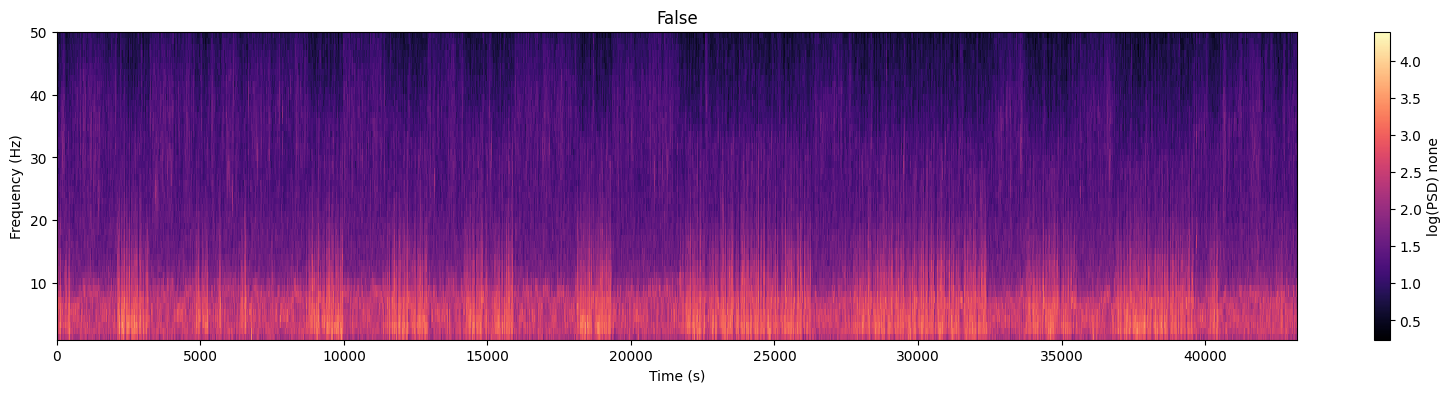

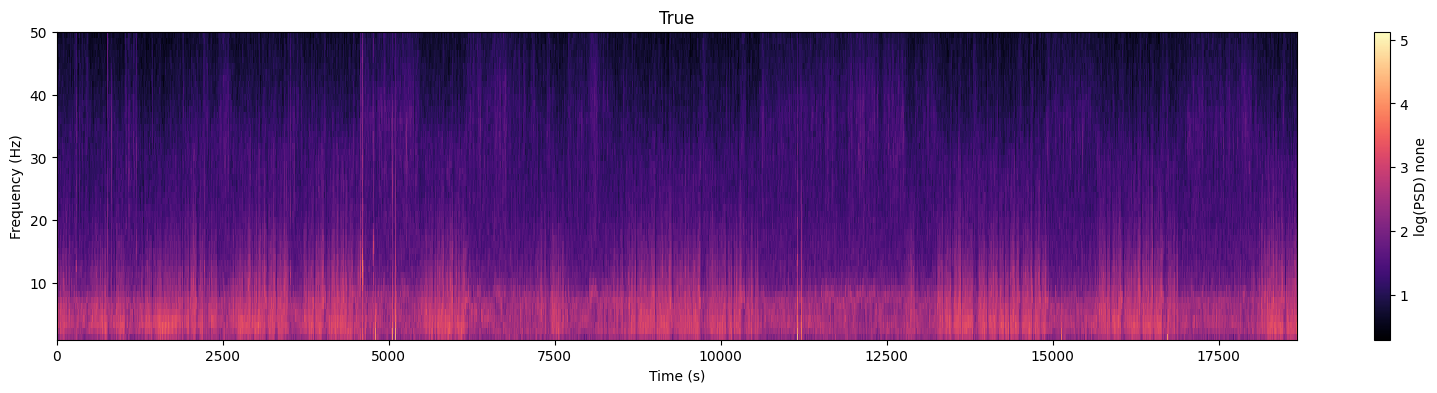

In [21]:
ap = AnimalPlotter(war)
# print(ap.window_result.result.index.size)

# ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# # ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# # ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')
# ap.plot_psd_histogram(['isday'], figsize=(10, 4), avg_channels=True)
ap.plot_psd_spectrogram(['isday'], figsize=(20, 4), mode='none')

## Miscellaneous Code

In [ ]:
%%script false
lan = core.LongRecordingAnalyzer(lrec, 100)
print(lan.n_fragments)

for i in range(lan.n_fragments):
    if i == 10:
        break
    lan.compute_rms(i)
    lan.compute_ampvar(i)
    f, psd = lan.compute_psd(i)
    lan.compute_psdband(i, f_psd=(f, psd))
    lan.compute_psdtotal(i, f_psd=(f, psd))
    mb = lan.compute_psdslope(i, f_psd=(f, psd))
    lan.compute_cohere(i)
    corr = lan.compute_corr(i)
    print(corr)

    # plt.imshow(corr)
    # plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.loglog(f, psd)
for i, (m,b) in enumerate(mb):
    ax.plot(f, 10**(b + m * np.log10(f)), c=f'C{i}')
ax.set_ylabel("PSD (uV^2/Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.axvline(60, c='black', ls='--', alpha=0.25)
plt.show()

In [ ]:
%%script false
# Computationally heavy tests
# lan.compute_spikes() 
# lan.compute_wavetemp()
# lan.compute_nspike(10)
wt, wts = lan.get_temps_from_wavetemp()

for wtch in wts:
    if wtch is not None:
        print(wtch.shape)
    else:
        continue
    fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
    for i in range(wtch.shape[0]):
        ax.plot(wtch[i, :, :])

In [ ]:
%%script false
temp = np.array(war.filter_rms_range(war.result)['rms'].tolist())
print(temp)
print(np.count_nonzero(np.isnan(temp)))
for i in range(10):
    hist, bins = np.histogram(temp[:, i], bins=np.linspace(-4, 4, 100), density=True)
    plt.hist(temp[:, i], bins=np.linspace(-4, 4, 100), density=True, color=f'C{i}', alpha=0.25)
    density = gaussian_kde(temp[~np.isnan(temp[:, i]), i])
    # print(x.shape, density(x).shape)
    plt.plot(bins, density(bins), c=f'C{i}')
    # plt.hist(temp[:, i], )
    
print(temp)